Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization
import numpy as np
from tensorflow.nn import softmax
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNet
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer


Load data and preprocess

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

# Ensure the labels are 1D
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

DenseNet with experiments

In [3]:
class CustomLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.output_dim])
        super().build(input_shape)

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)



# Define the hyperparameters
num_layers = [2, 3]
optimizers = [Adam,  SGD]
batch_size = 128
learning_rate = 0.001

# Determine the number of classes from the labels
num_classes = test_labels.shape[1]

# Initialize the list to store the results
results = []
histories = [] 

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

for num_layer in num_layers:
    for optimizer in optimizers:
        for activation_func in ['relu', 'tanh']:  # Add activation function variation
            for num_filters in [32, 64]:  # Add different number of filters
                # Define the base model
                base_model = Sequential()
                base_model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(32, 32, 3)))
                base_model.add(MaxPooling2D((2, 2)))
                # Add the custom layer
                base_model.add(CustomLayer(64))

                for _ in range(num_layer):
                    base_model.add(Dense(128, activation=activation_func))
                    base_model.add(Dropout(0.2))  # Add dropout for regularization
                base_model.add(Flatten())
                base_model.add(Dense(num_classes, activation='softmax'))

                # Compile the model
                base_model.compile(optimizer=optimizer(learning_rate=learning_rate),
                                   loss='categorical_crossentropy',
                                   metrics=['accuracy'])

                # Train the model with data augmentation
                history = base_model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                                          epochs=100,
                                          validation_data=(test_images, test_labels),
                                          callbacks=[early_stopping])

                histories.append(history)

                
                # Evaluate the model on the test data
                predictions = base_model.predict(test_images)
                y_pred = np.argmax(predictions, axis=1)

                # Convert y_pred from label encoding to one-hot encoding
                y_pred_one_hot = to_categorical(y_pred)

                # Convert test_labels from one-hot encoding to label encoding
                test_labels_decoded = np.argmax(test_labels, axis=1)

                # Calculate the true positives, true negatives, false positives, and false negatives
                tp = np.sum((y_pred == 1) & (test_labels_decoded == 1))
                tn = np.sum((y_pred == 0) & (test_labels_decoded == 0))
                fp = np.sum((y_pred == 1) & (test_labels_decoded == 0))
                fn = np.sum((y_pred == 0) & (test_labels_decoded == 1))

                # Calculate the recall
                recall = tp / (tp + fn)

                # Calculate the precision
                precision = tp / (tp + fp)

                # Calculate the F1 score
                f1_score_value = 2 * precision * recall / (precision + recall)

                # Calculate the accuracy
                accuracy = np.mean(y_pred == test_labels_decoded)

                # Calculate the ROC AUC
                roc_auc = roc_auc_score(test_labels, y_pred_one_hot, multi_class='ovr')

                # Append the results to the list
                results.append({
                    'Model': f"Model with {num_layer} layers, optimizer: {optimizer.__name__}, activation func: {activation_func}, filters: {num_filters}",
                    'Accuracy': accuracy,
                    'Recall': recall,
                    'Precision': precision,
                    'F1 Score': f1_score_value,
                    'TP': tp / num_classes,
                    'TN': tn / num_classes,
                    'FP': fp / num_classes,
                    'FN': fn / num_classes,
                    'ROC AUC': roc_auc
                })

# Convert the list to a DataFrame after all models have been evaluated
results_df = pd.DataFrame(results)
print(results_df)
# Print the DataFrame without index
print(results_df.to_string(index=False))

Epoch 1/100
391/391 [==============================] - 117s 298ms/step - loss: 1.5937 - accuracy: 0.4263 - val_loss: 1.4027 - val_accuracy: 0.5062
Epoch 2/100
391/391 [==============================] - 117s 298ms/step - loss: 1.3377 - accuracy: 0.5194 - val_loss: 1.2453 - val_accuracy: 0.5625
Epoch 3/100
391/391 [==============================] - 122s 312ms/step - loss: 1.2451 - accuracy: 0.5580 - val_loss: 1.1052 - val_accuracy: 0.6057
Epoch 4/100
391/391 [==============================] - 121s 309ms/step - loss: 1.1863 - accuracy: 0.5793 - val_loss: 1.1252 - val_accuracy: 0.6058
Epoch 5/100
391/391 [==============================] - 121s 309ms/step - loss: 1.1424 - accuracy: 0.5983 - val_loss: 1.0668 - val_accuracy: 0.6224
Epoch 6/100
391/391 [==============================] - 121s 309ms/step - loss: 1.0942 - accuracy: 0.6155 - val_loss: 0.9642 - val_accuracy: 0.6628
Epoch 7/100
391/391 [==============================] - 121s 309ms/step - loss: 1.0716 - accuracy: 0.6220 - val_loss: 1

visualizing densenet

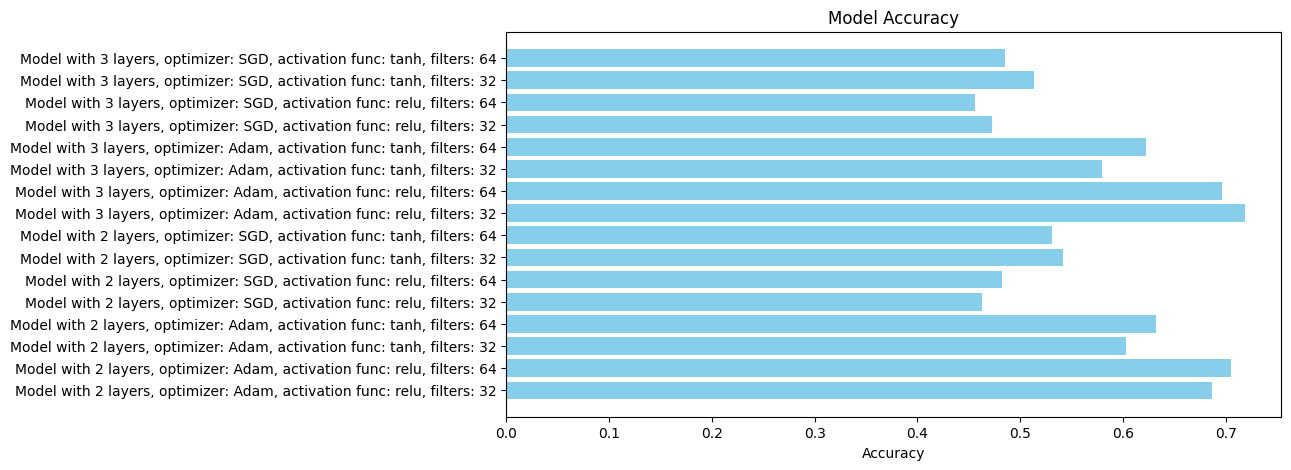

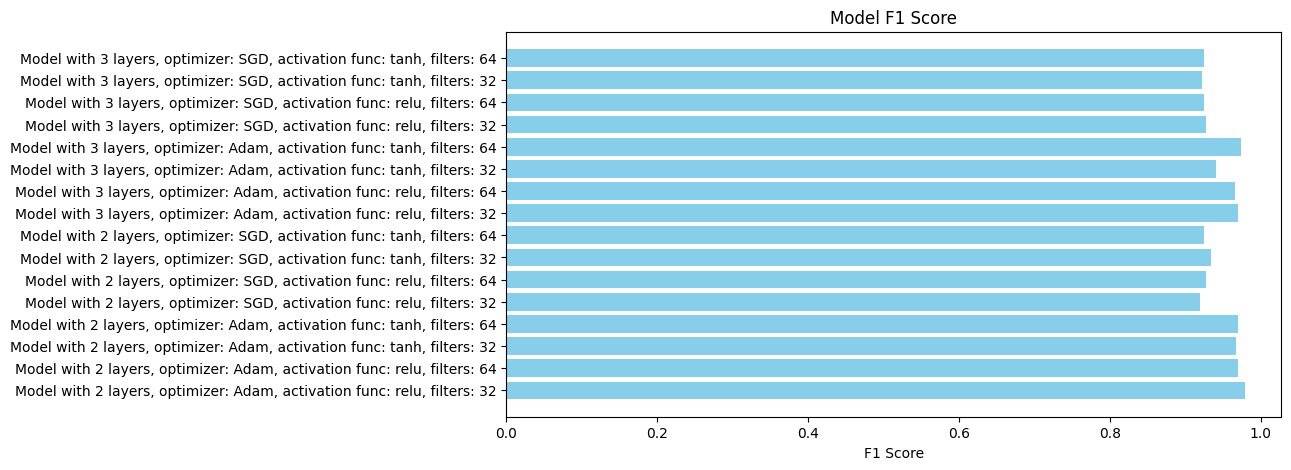

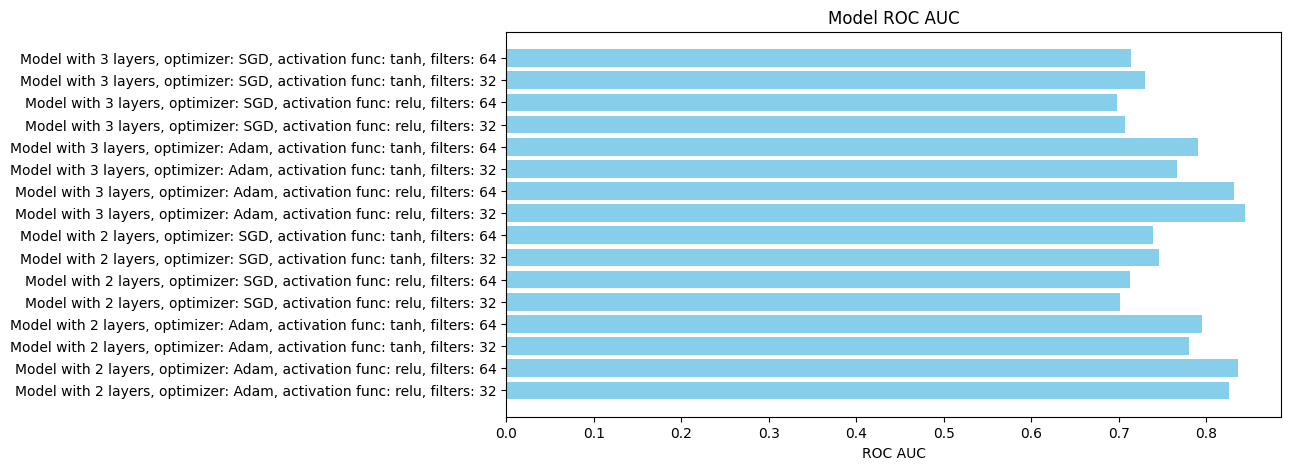

In [7]:

# Plotting Accuracy for each model
plt.figure(figsize=(10, 5))
plt.barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

# Plotting F1 Score for each model
plt.figure(figsize=(10, 5))
plt.barh(results_df['Model'], results_df['F1 Score'], color='skyblue')
plt.xlabel('F1 Score')
plt.title('Model F1 Score')
plt.show()

# Plotting ROC AUC for each model
plt.figure(figsize=(10, 5))
plt.barh(results_df['Model'], results_df['ROC AUC'], color='skyblue')
plt.xlabel('ROC AUC')
plt.title('Model ROC AUC')
plt.show()


Visualisation

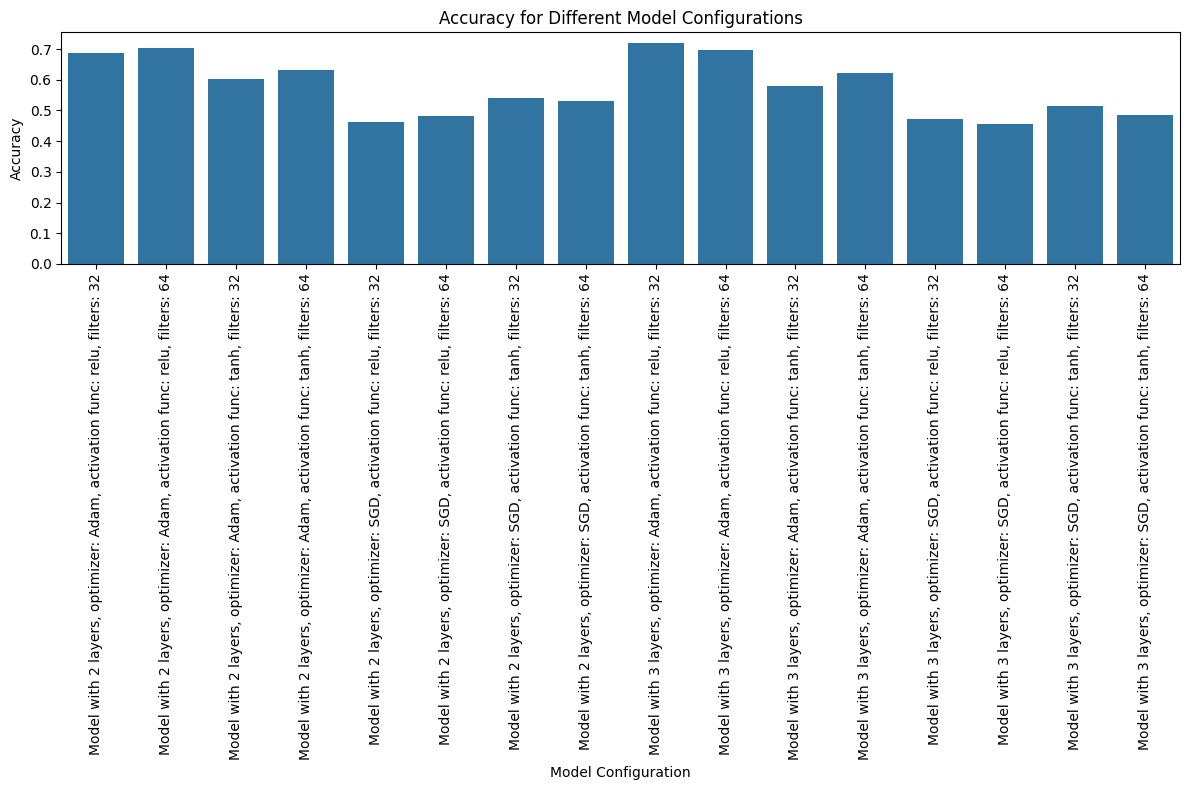

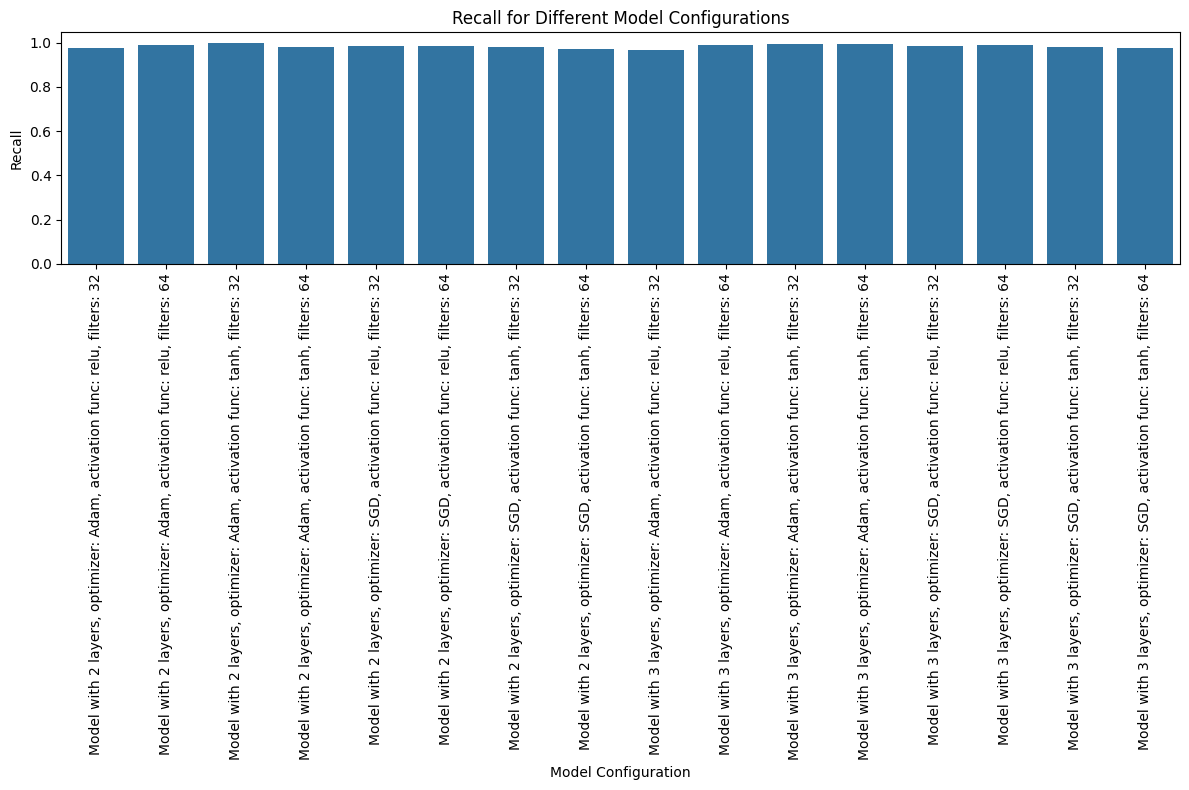

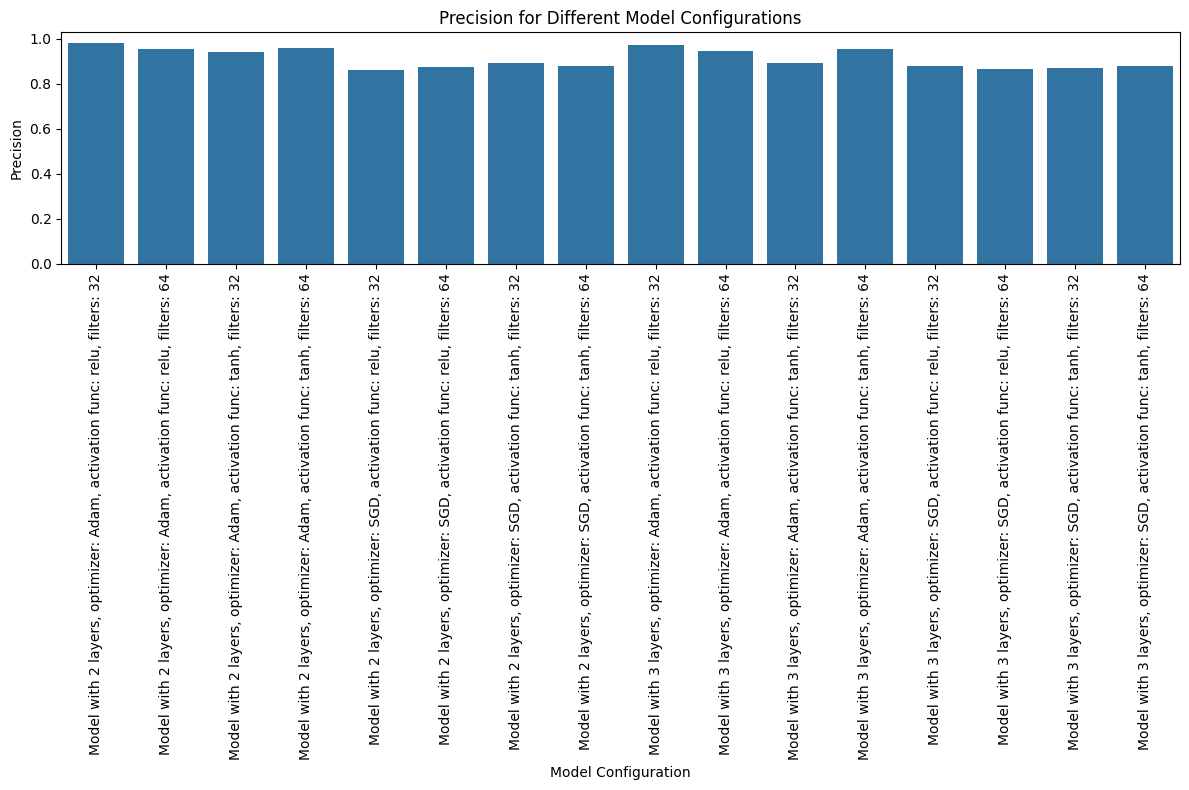

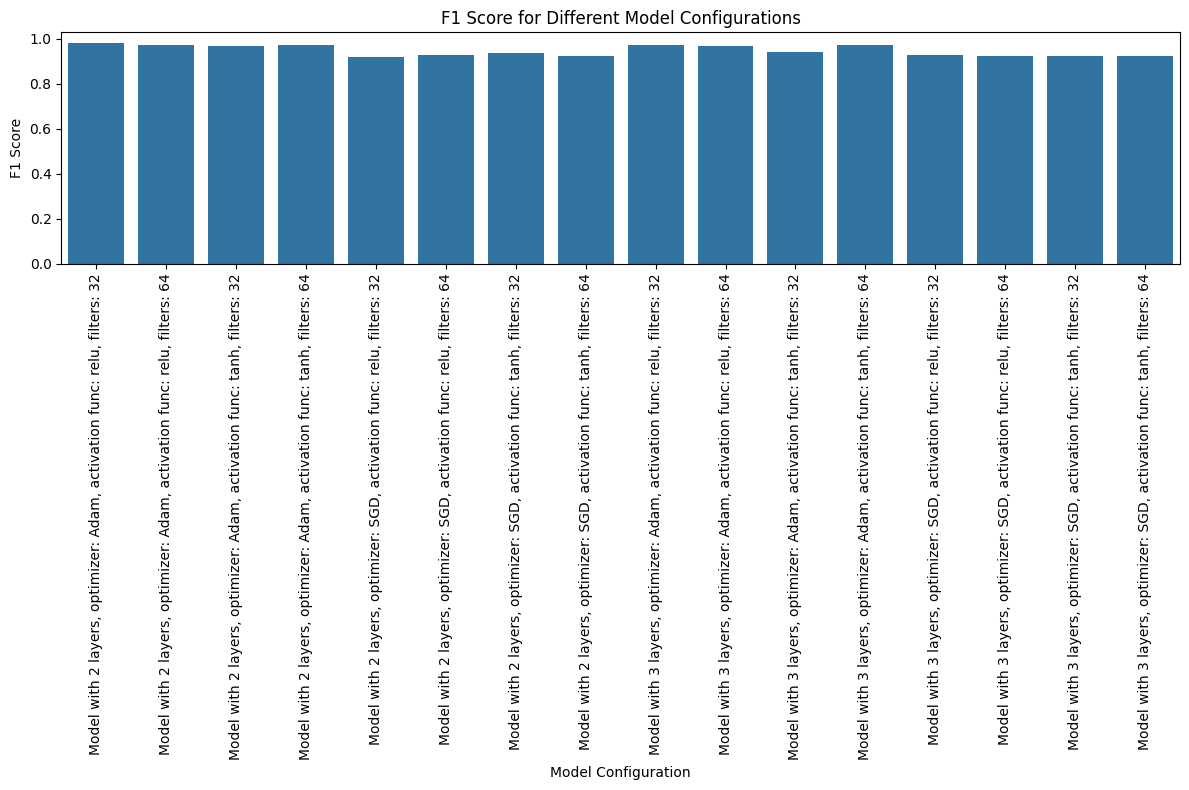

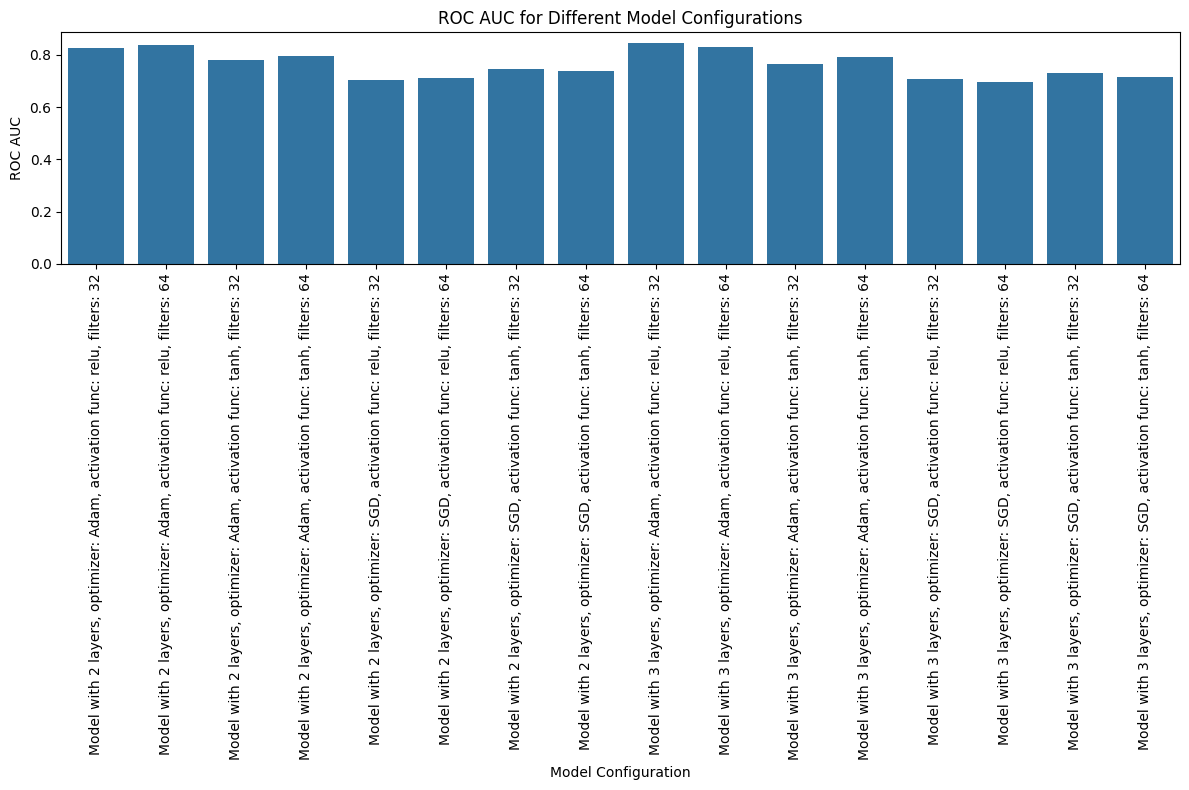

In [14]:
# Function to plot metrics
def plot_metrics(results_df, metric):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.xticks(rotation=90)
    plt.title(f'{metric} for Different Model Configurations')
    plt.xlabel('Model Configuration')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

# Plot Accuracy
plot_metrics(results_df, 'Accuracy')

# Plot Recall
plot_metrics(results_df, 'Recall')

# Plot Precision
plot_metrics(results_df, 'Precision')

# Plot F1 Score
plot_metrics(results_df, 'F1 Score')

# Plot ROC AUC
plot_metrics(results_df, 'ROC AUC')



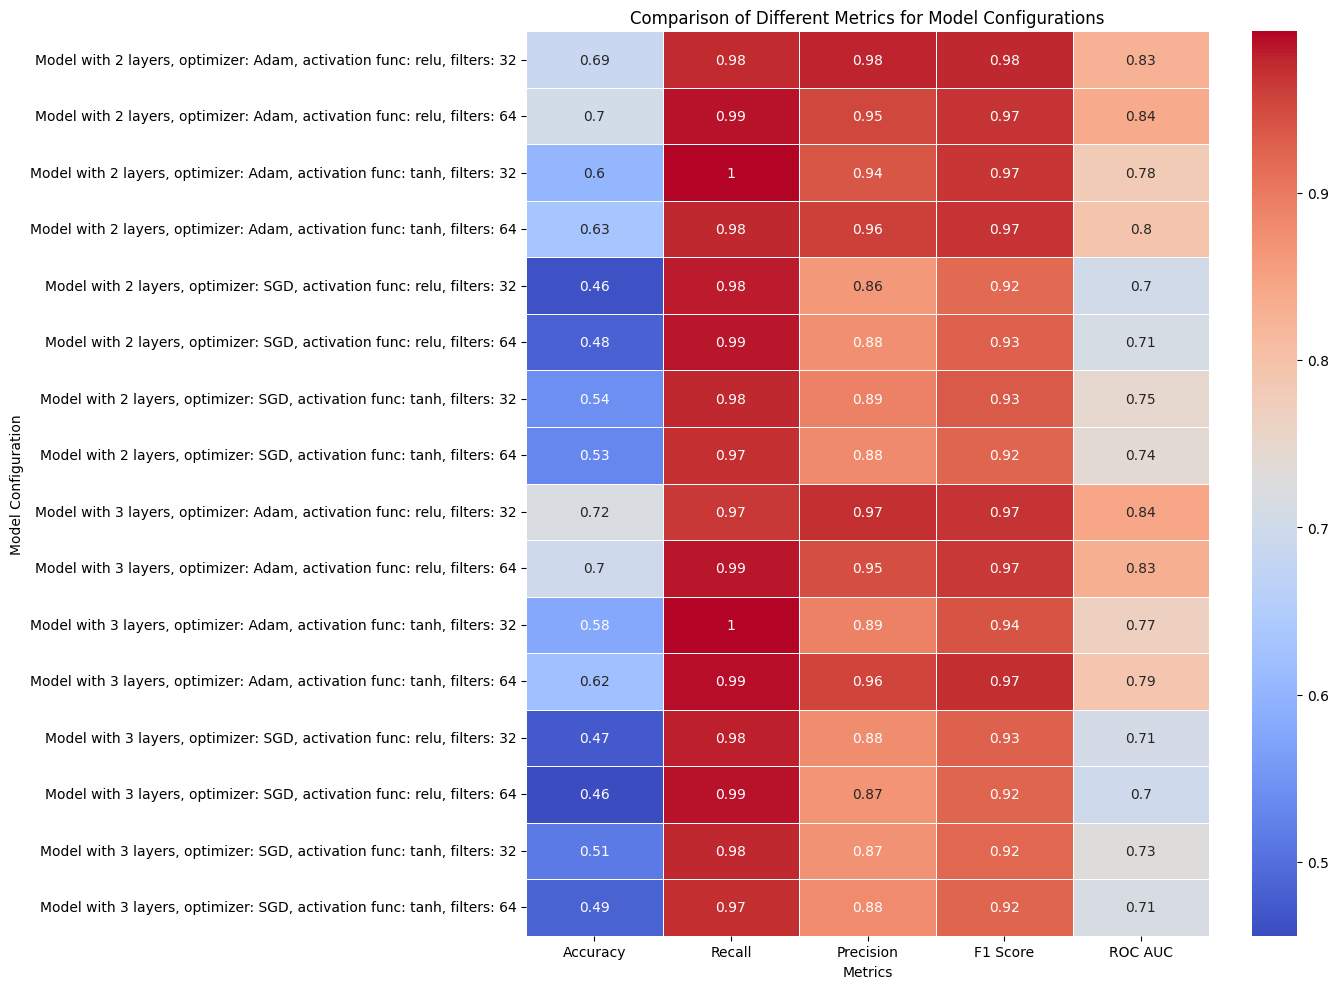

In [87]:

# Heatmap for a comprehensive comparison
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'ROC AUC']
pivot_table = results_df.set_index('Model')[metrics]

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Comparison of Different Metrics for Model Configurations')
plt.xlabel('Metrics')
plt.ylabel('Model Configuration')
plt.tight_layout()
plt.show()

Length of histories list: 4
Model to index mapping: {'Model with 2 layers, optimizer: Adam, activation func: relu, filters: 32': 0, 'Model with 2 layers, optimizer: Adam, activation func: relu, filters: 64': 1, 'Model with 2 layers, optimizer: Adam, activation func: tanh, filters: 32': 2, 'Model with 2 layers, optimizer: Adam, activation func: tanh, filters: 64': 3, 'Model with 2 layers, optimizer: SGD, activation func: relu, filters: 32': 4, 'Model with 2 layers, optimizer: SGD, activation func: relu, filters: 64': 5, 'Model with 2 layers, optimizer: SGD, activation func: tanh, filters: 32': 6, 'Model with 2 layers, optimizer: SGD, activation func: tanh, filters: 64': 7, 'Model with 3 layers, optimizer: Adam, activation func: relu, filters: 32': 8, 'Model with 3 layers, optimizer: Adam, activation func: relu, filters: 64': 9, 'Model with 3 layers, optimizer: Adam, activation func: tanh, filters: 32': 10, 'Model with 3 layers, optimizer: Adam, activation func: tanh, filters: 64': 11, '

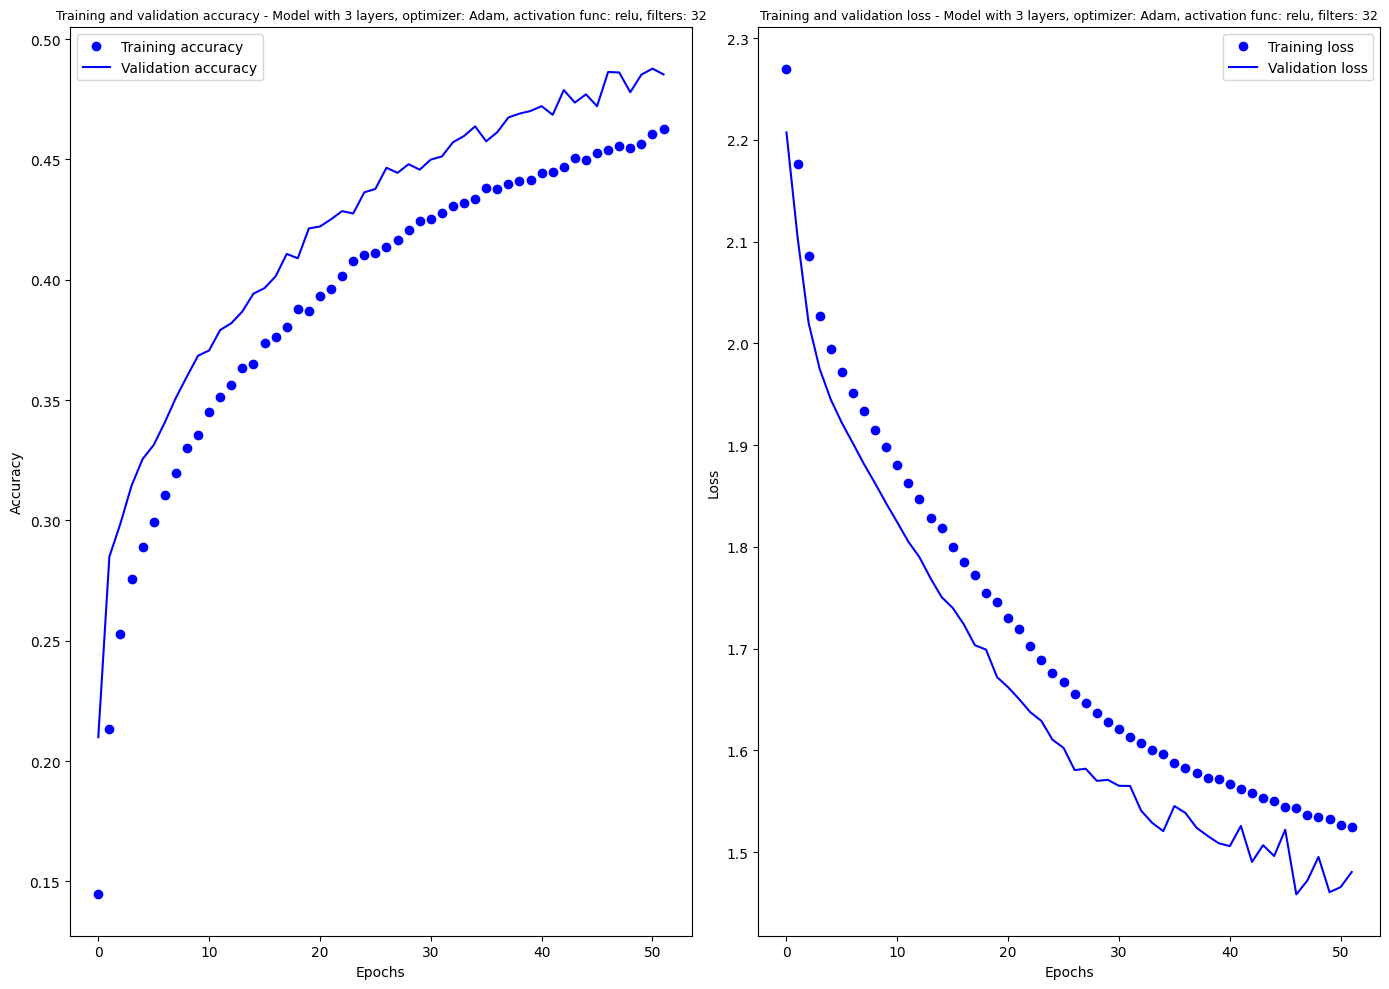

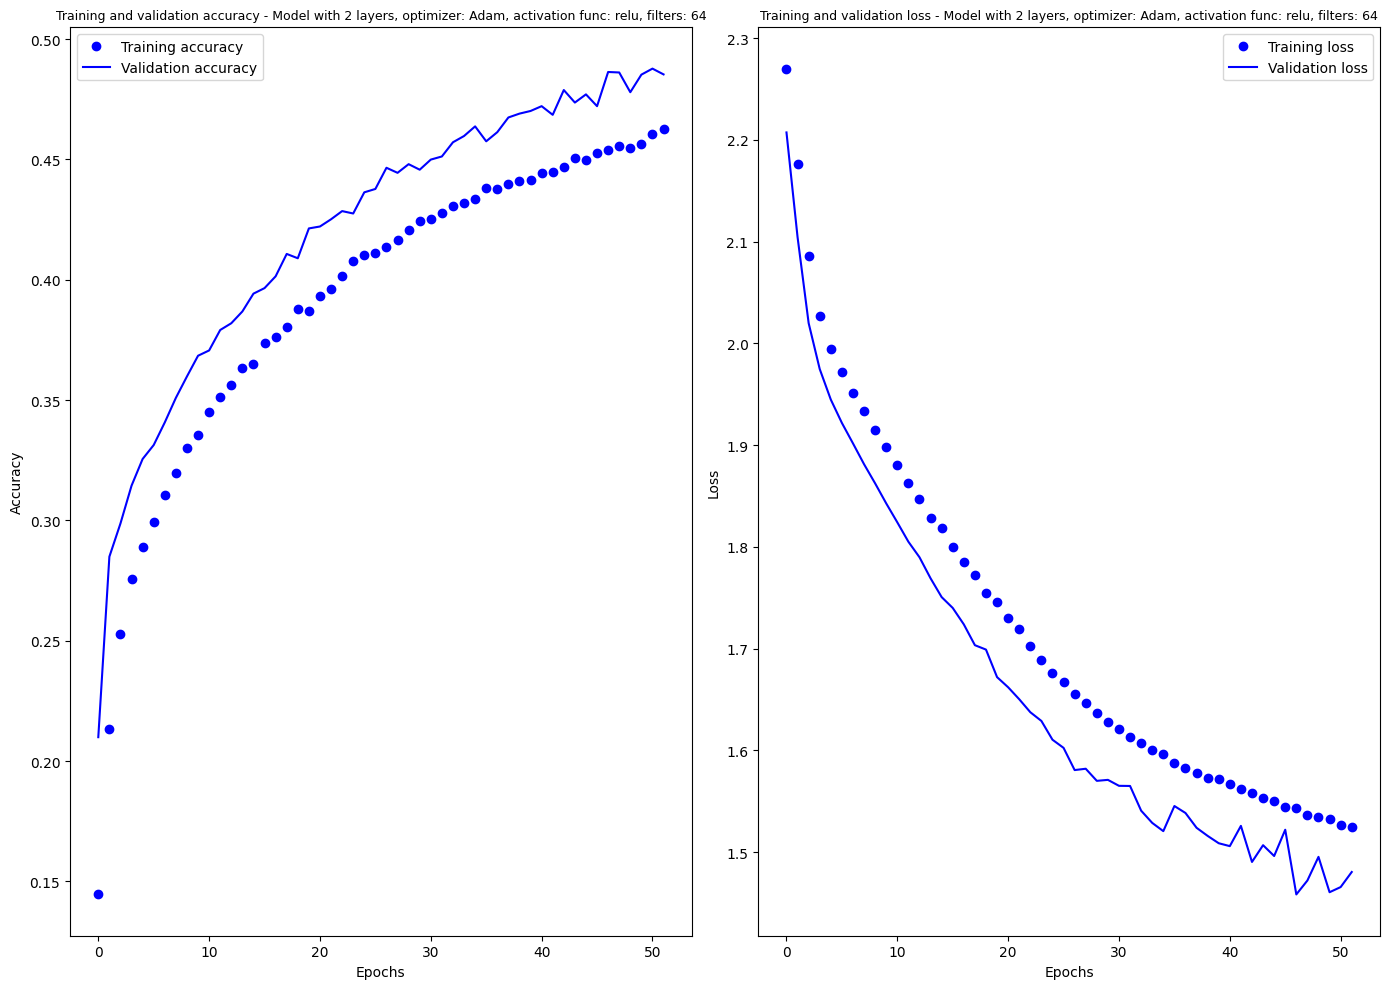

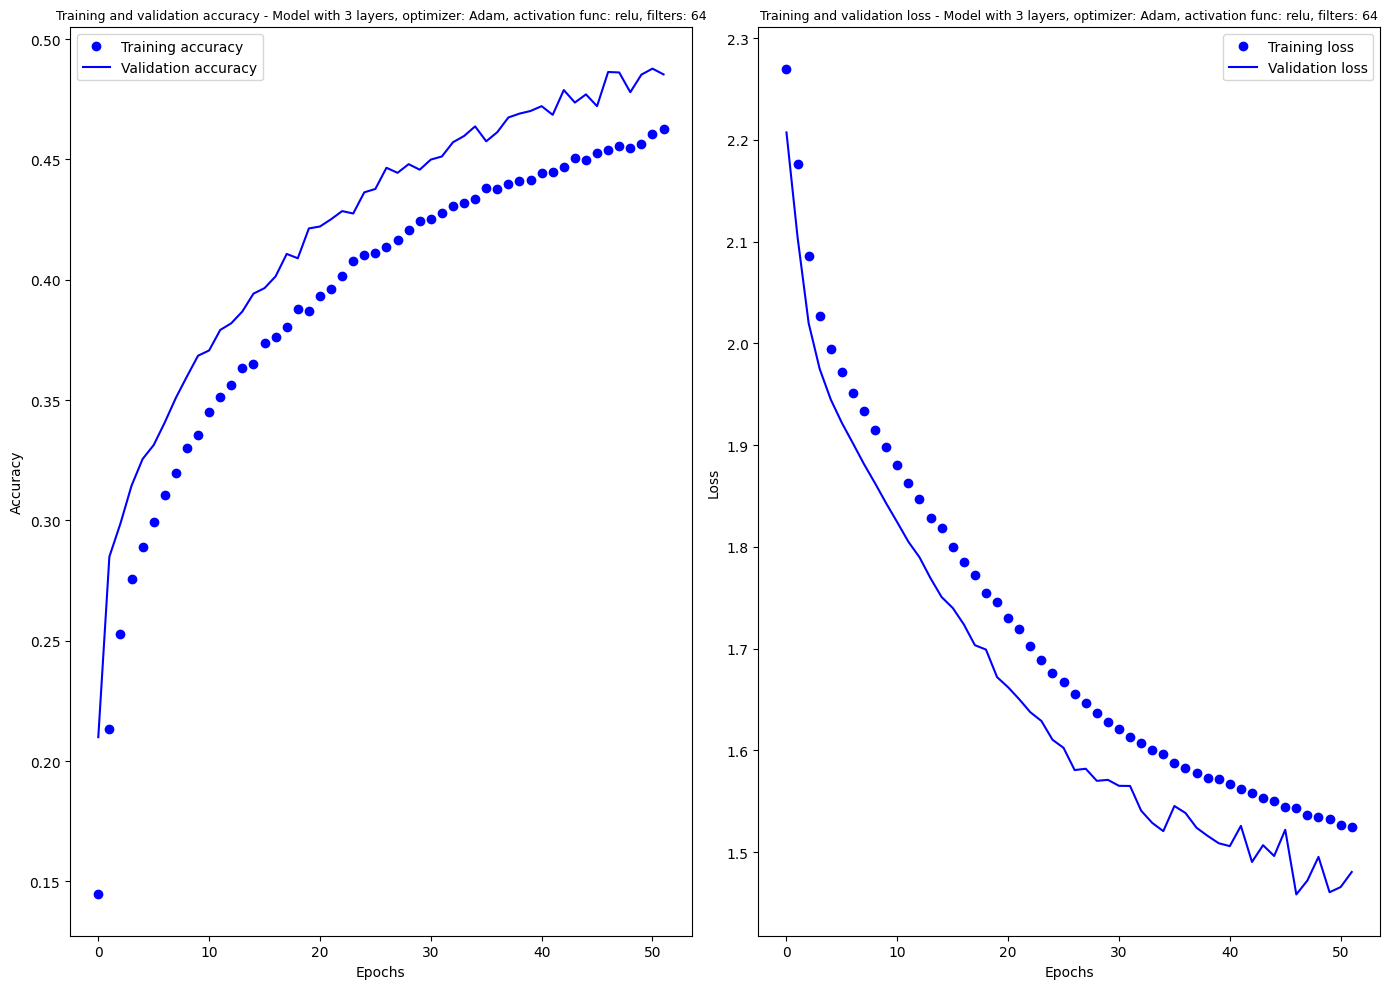

In [86]:
# Verify the length of histories list
print("Length of histories list:", len(history.history))

# Create a mapping from model names to their corresponding index in the histories list
model_to_index = {model: idx for idx, model in enumerate(results_df['Model'])}




# Print the mapping to ensure it is correct
print("Model to index mapping:", model_to_index)

# Extract top 3 models based on Accuracy
top_3_models = results_df.nlargest(3, 'Accuracy')
print("Top 3 models based on Accuracy:")
print(top_3_models[['Model', 'Accuracy']])


           

# Plot learning curves for the top 3 models
for model_name in top_3_models['Model']:
    if model_name in model_to_index:
        index = model_to_index[model_name]
       # if index < len(history.history):  # Ensure index is within the range of histories list

       
        # Colors and markers for the top 3 models
        colors = ['b', 'g', 'r']
        markers = ['o', 's', 'D']

        # Plot learning curves for the top 3 models
        plt.figure(figsize=(14, 10))  # Adjust figure size to accommodate both plots
            # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], 'bo', label='Training accuracy')
        plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
        plt.title(f'Training and validation accuracy - {model_name}',fontsize=9)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], 'bo', label='Training loss')
        plt.plot(history.history['val_loss'], 'b', label='Validation loss')
        plt.title(f'Training and validation loss - {model_name}',fontsize= 9)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()